In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from random_access.random_access import *

df = randomaccess_eventdriven(num_channels:=2, 
             stas_per_channel:=[5, 10], 
             beaconinterval:=100000, 
             num_episodes:=10,
             frametxslot:=300, 
             per:=[0, 0.5])

df = df.sort_values(by=['time', 'channel']).reset_index(drop=True)
df.to_csv('test.csv', index=False)

/tmp/ipykernel_167522/1446521525.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tx = df_tx.fillna(0)
/tmp/ipykernel_167522/1446521525.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_aoi = df_aoi.fillna(0)


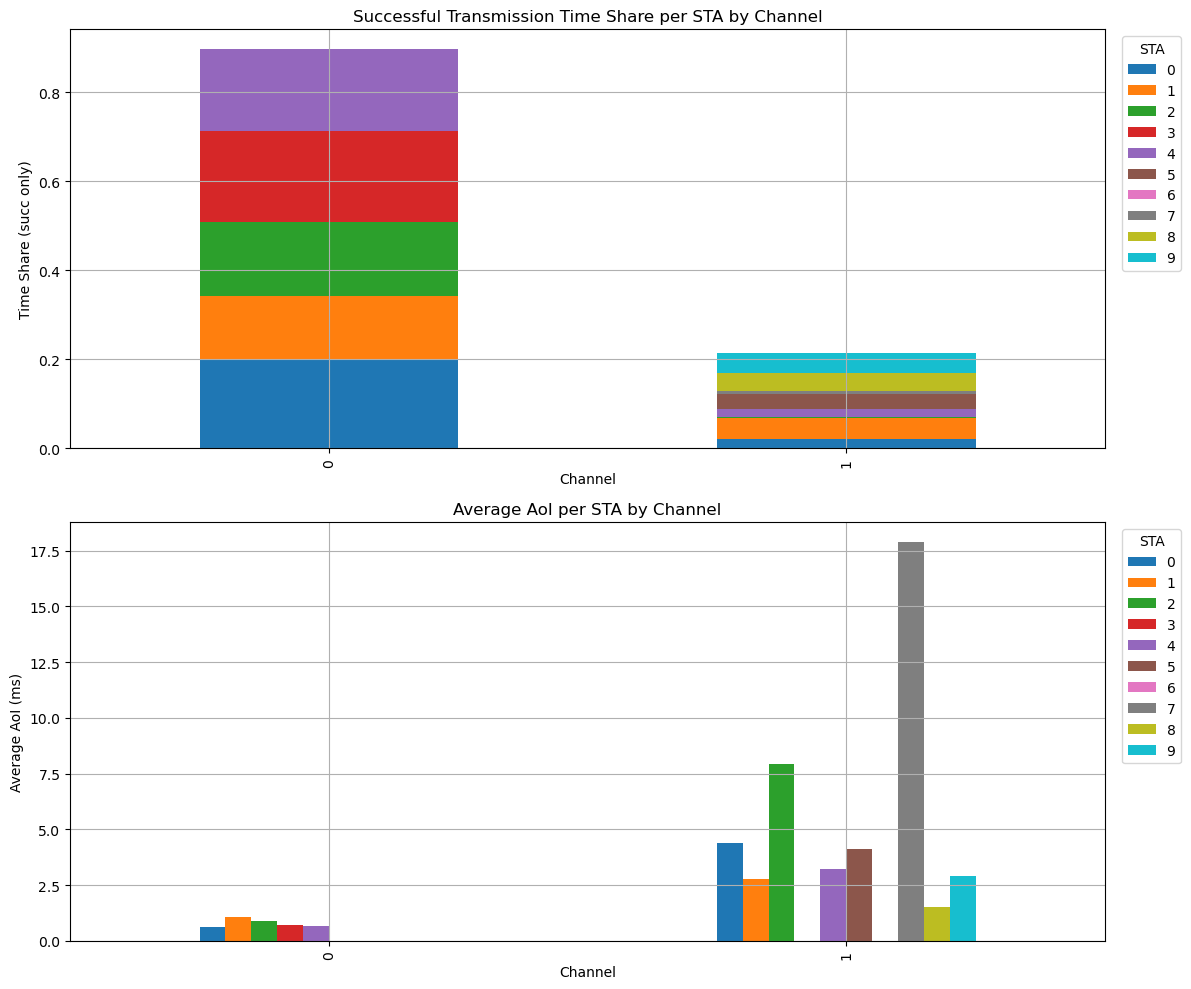

In [6]:
# 시뮬레이션 종료 시간
sim_end_time = df['time'].max()

# 채널별 STA 성능 기록
channel_sta_tx = {}  # channel -> {sta: time_share}
channel_sta_aoi = {}  # channel -> {sta: AoI in ms}

for channel in range(num_channels):
    df_ch = df[df['channel'] == channel]
    sta_tx = {}
    sta_aoi = {}

    for sta in np.array(range(stas_per_channel[channel])):
        df_sta = df_ch[df_ch['node'] == sta]
        df_succ = df_sta[df_sta['result'] == 'succ']

        time_share = df_succ["duration"].sum() / sim_end_time
        sta_tx[sta] = time_share

        if len(df_succ) > 0:
            aois = df_succ['time'] - df_succ['timestamp']
            sta_aoi[sta] = aois.mean() / 1000.0  # μs → ms
        else:
            sta_aoi[sta] = float('nan')

    channel_sta_tx[channel] = sta_tx
    channel_sta_aoi[channel] = sta_aoi

# 공통 STA 집합 확보 (모든 STA 포함, 누락된 값은 0 또는 NaN)
all_stas = sorted(set(df['node'].unique()))
df_tx = pd.DataFrame(columns=all_stas, index=channel_sta_tx.keys())
df_aoi = pd.DataFrame(columns=all_stas, index=channel_sta_aoi.keys())

# 값 채우기
for ch in channel_sta_tx:
    for sta in channel_sta_tx[ch]:
        df_tx.loc[ch, sta] = channel_sta_tx[ch][sta]
        df_aoi.loc[ch, sta] = channel_sta_aoi[ch][sta]

df_tx = df_tx.fillna(0)
df_aoi = df_aoi.fillna(0)

# 인덱스(채널 번호) 정렬
df_tx = df_tx.sort_index()
df_aoi = df_aoi.sort_index()

# ---------- Subplot ----------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Time Share
df_tx.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Successful Transmission Time Share per STA by Channel')
ax1.set_ylabel('Time Share (succ only)')
ax1.set_xlabel('Channel')
ax1.grid(True)
ax1.legend(title='STA', bbox_to_anchor=(1.01, 1), loc='upper left')

# Average AoI
df_aoi.plot(kind='bar', ax=ax2)
ax2.set_title('Average AoI per STA by Channel')
ax2.set_ylabel('Average AoI (ms)')
ax2.set_xlabel('Channel')
ax2.grid(True)
ax2.legend(title='STA', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()